<a href="https://colab.research.google.com/github/rajaonsonella/csc2541_lab1/blob/main/lab1_pre_module.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC2541 - Lab 1: Deep Learning for structure-based drug design (SBDD)

Structure-based drug design (SBDD) aims at designing small-molecule ligands that bind with high affinity and specificity to pre-determined protein targets which have been identified as having therapeutic potential. Specifically, this approach focuses on leveraging the 3D structure of the protein target to rationally design a ligand.

In this lab, we aim at giving you an introduction to SBDD and the latest deep learning models used in the field. The lab is structured into three parts

### Table of Content

1.   Pre-module: Introduction to the Protein Data Bank (PDB) (~30 mins)
2.   Module: Exploring how ML does at Ligand pose prediction (~50 mins)
3.   Post-module (assignment): Evaluating a state of the art ML model (Boltz2) on various protein ligand complex pose prediction (~60 mins)

# Colab Set Up

In [ ]:
from IPython.utils import io
print('Downloading necessary libraries...')
def install_libraries():
  !pip install py3Dmol -q
  !pip install biopython -q
with io.capture_output() as captured:
  install_libraries()

In [ ]:
import ipywidgets
from IPython.display import display

# Pre-module: Introduction to the Protein Data Bank (PDB)

The Protein Data Bank (PDB) is a **global repository of 3D structural data for biological macromolecules** like proteins, DNA, RNA, and their complexes with ligands or drugs.


It stores experimentally determined structures obtained through techniques such as X-ray crystallography, nuclear magnetic resonance (NMR) spectroscopy, and cryo-electron microscopy (cryo-EM). Each entry in the PDB contains atomic coordinates, experimental details, and annotations describing function and interactions of the macromolecule.

Learn more about the history of PDB [here](https://www.rcsb.org/pages/about-us/history) and check out the overall growth of the database [here](https://www.rcsb.org/stats/growth/growth-released-structures)!

**In this pre-module we are going to:**

* Review the basics about proteins
* Learn more about the file format used to store this type of data
* Learn how to programmatically retrieve protein structures and extract key metadata
* Visualize protein structures interactively in 3D using Python tools

## Protein 101 recap

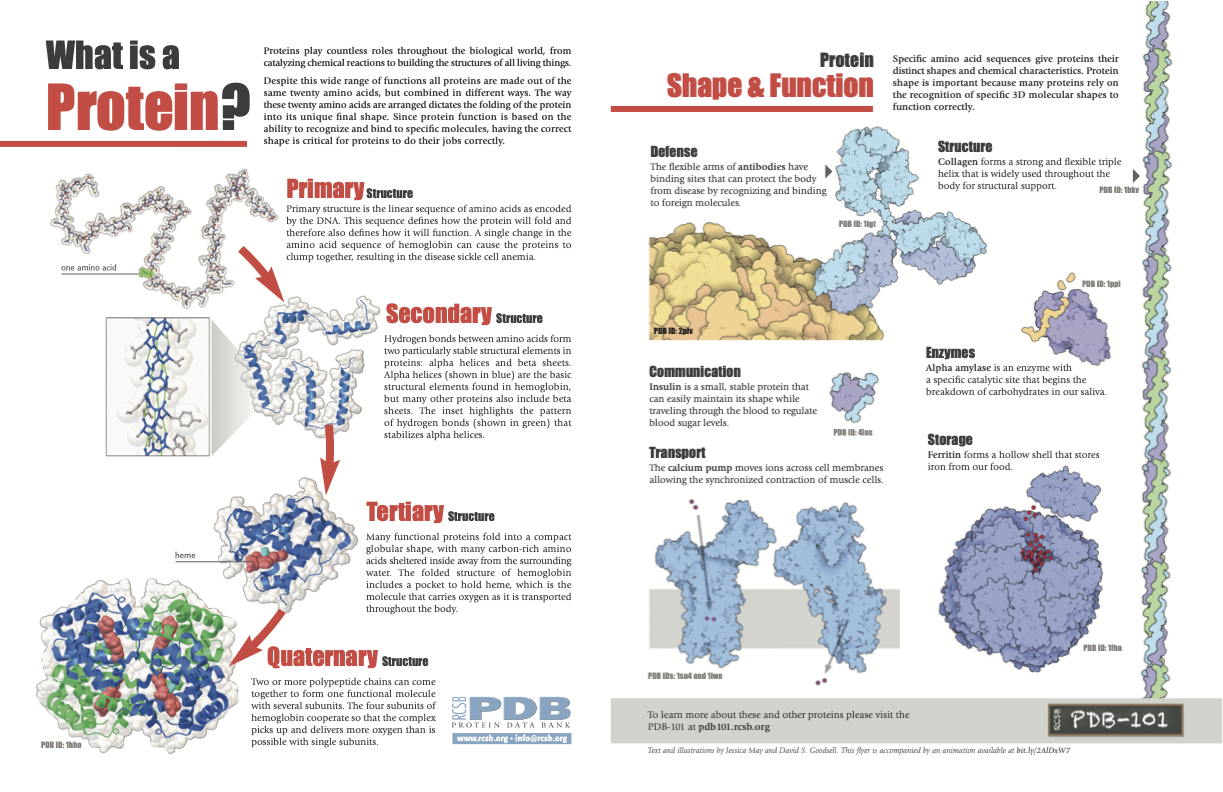

[Image source](https://pdb101.rcsb.org/learn/flyers-posters-and-calendars/flyer/what-is-a-protein)


## The PDB & PDBx/mmCIF file formats

The files found in the PDB are available in several formats (PDB, mmCIF, XML). We will focus on the PDB and PDBx/mmCIF file formats, as the former is widely used and the latter is the current preferred format.


**Note:** This is a quick intro to the file formats, full documentation can be found at [https://mmcif.wwpdb.org/](https://mmcif.wwpdb.org/) for the mmCIF format and [this website](https://www.rbvi.ucsf.edu/chimera/docs/UsersGuide/tutorials/pdbintro.html) is a good introduction to the PDB format.

### The PDB format

While the PDB format is a legacy file format from the Protein Data Bank, it is still widely used in the field. For that reason, we will spend a bit of time exploring it.

In [ ]:
# Download an PDB file

# Colab tip -- You can download the file to your local machine by:
# 1) clicking on the folder icon on the colab menu
# 2) locating the file and double-clicking on it

# Let's specify the PDB ID of the file we want to download
pdb_id = "4INS"

import urllib.request
urllib.request.urlretrieve(f"https://files.rcsb.org/download/{pdb_id}.pdb", f"{pdb_id}.pdb")

# View first few lines, feel free to open the file into a text editor to check out the entirety of the file!
num_lines_to_print = 10
with open("4INS.pdb") as f:
    print(f"Printing the first {num_lines_to_print} lines in the file: \n")
    for _ in range(num_lines_to_print):
        print(f.readline().strip())

Printing the first 10 lines in the file: 

HEADER    HORMONE                                 10-JUL-89   4INS
TITLE     THE STRUCTURE OF 2ZN PIG INSULIN CRYSTALS AT 1.5 ANGSTROMS RESOLUTION
COMPND    MOL_ID: 1;
COMPND   2 MOLECULE: INSULIN (CHAIN A);
COMPND   3 CHAIN: A, C;
COMPND   4 ENGINEERED: YES;
COMPND   5 MOL_ID: 2;
COMPND   6 MOLECULE: INSULIN (CHAIN B);
COMPND   7 CHAIN: B, D;
COMPND   8 ENGINEERED: YES


Let's print lines 580-590

In [ ]:
with open("4INS.pdb") as f:
    all_lines = f.readlines()

for l in all_lines[580:590]:
    print(l.strip())

ATOM      1  N   GLY A   1      -8.863  16.944  14.289  1.00 21.88           N
ATOM      2  CA  GLY A   1      -9.929  17.026  13.244  1.00 22.85           C
ATOM      3  C   GLY A   1     -10.051  15.625  12.618  1.00 43.92           C
ATOM      4  O   GLY A   1      -9.782  14.728  13.407  1.00 25.22           O
ATOM      5  N   ILE A   2     -10.333  15.531  11.332  1.00 26.28           N
ATOM      6  CA  ILE A   2     -10.488  14.266  10.600  1.00 20.84           C
ATOM      7  C   ILE A   2      -9.367  13.302  10.658  1.00 11.81           C
ATOM      8  O   ILE A   2      -9.580  12.092  10.969  1.00 20.31           O
ATOM      9  CB  ILE A   2     -10.883  14.493   9.095  1.00 40.00           C
ATOM     10  CG1 ILE A   2     -11.579  13.146   8.697  1.00 36.74           C


This type of lines is what we are usually interested in when dealing with biological structural data in ML. These lines contain the 3D information of the protein/complex structure.


Each part of these line represents specific information about an atom in the macromolecule. Here’s what each section means for the first line:

| **Value**| **Meaning**|
|-|-|
| **ATOM**                   | This indicates the entry type. "ATOM" refers to a regular atom (as opposed to "HETATM" for heteroatoms).  |
| **1**                      | The **atom serial number** (uniquely identifies the atom in the structure).                               |
| **N**                      | The **atom name**. "N" represents the **nitrogen atom** of the amino acid.                                |
| **GLY**                    | The **residue name**. This atom belongs to the amino acid **glycine**.                                    |
| **A**                      | The **chain identifier**. This atom is part of **chain A** in the structure.                              |
| **1**                      | The **residue sequence number**. This atom is part of **residue 1** in chain A (first amino acid).        |
| **-8.863  16.944  14.289** | The **X, Y, Z coordinates** of the atom in 3D space (respectively, in angstroms).                         |
| **1.00**                   | The **occupancy** factor. This indicates the likelihood of this atom being present at this position.      |
| **21.88**                  | The **temperature factor (B-factor)**, indicating the flexibility or uncertainty of the atom's position.  |
| **N**                      | The **element symbol**. This atom is **nitrogen (N)**.                                                    |



### The PDBx/mmCIF file format

Let's first download a file and open it to see what the format looks like:

In [ ]:
# Download an mmCIF file

# Let's specify the PDB ID of the file we want to download
pdb_id = "4INS"

import urllib.request
urllib.request.urlretrieve(f"https://files.rcsb.org/download/{pdb_id}.cif", f"{pdb_id}.cif")

# View first few lines, feel free to open the file into a text editor to check out the entirety of the file!
num_lines_to_print = 10
with open("4INS.cif") as f:
    print(f"Printing the first {num_lines_to_print} lines in the file: \n")
    for _ in range(num_lines_to_print):
        print(f.readline().strip())

Printing the first 10 lines in the file: 

data_4INS
#
_entry.id   4INS
#
_audit_conform.dict_name       mmcif_pdbx.dic
_audit_conform.dict_version    5.397
_audit_conform.dict_location   http://mmcif.pdb.org/dictionaries/ascii/mmcif_pdbx.dic
#
loop_
_database_2.database_id


The shift from PDB to mmCIF occurred because mmCIF offers better scalability, a more flexible data structure, and the ability to store complex and diverse data types. Unlike PDB, which was limited in handling large, high-resolution structures, mmCIF allows for better organization, easier data retrieval, and supports a wider range of information, making it more suitable for modern structural biology. Note that the format is very different when it comes to the content "around" the coordinates data, but the coordinates data itself is presented in a similar manner as the PDB format.

Let's print lines 2370-2380 and compare them to the one we printed above for the PDB format

In [ ]:
with open("4INS.cif") as f:
    all_lines = f.readlines()

for l in all_lines[2370:2380]:
    print(l.strip())

ATOM   1    N  N   . GLY A 1 1  ? -8.863  16.944 14.289  1.00 21.88  ? 1   GLY A N   1
ATOM   2    C  CA  . GLY A 1 1  ? -9.929  17.026 13.244  1.00 22.85  ? 1   GLY A CA  1
ATOM   3    C  C   . GLY A 1 1  ? -10.051 15.625 12.618  1.00 43.92  ? 1   GLY A C   1
ATOM   4    O  O   . GLY A 1 1  ? -9.782  14.728 13.407  1.00 25.22  ? 1   GLY A O   1
ATOM   5    N  N   . ILE A 1 2  ? -10.333 15.531 11.332  1.00 26.28  ? 2   ILE A N   1
ATOM   6    C  CA  . ILE A 1 2  ? -10.488 14.266 10.600  1.00 20.84  ? 2   ILE A CA  1
ATOM   7    C  C   . ILE A 1 2  ? -9.367  13.302 10.658  1.00 11.81  ? 2   ILE A C   1
ATOM   8    O  O   . ILE A 1 2  ? -9.580  12.092 10.969  1.00 20.31  ? 2   ILE A O   1
ATOM   9    C  CB  . ILE A 1 2  ? -10.883 14.493 9.095   1.00 40.00  ? 2   ILE A CB  1
ATOM   10   C  CG1 . ILE A 1 2  ? -11.579 13.146 8.697   1.00 36.74  ? 2   ILE A CG1 1


### Parsing structural data in Python

As you can see, it is quite challenging to handle these files "by ourselves" that's why many python libraries have built-in parsers to easily retrieve this data and focus on the rest. The lines we are usually interested in within this file are the one describing the 3D structure of the protein, let's use of of those python packages to extract this information from this file more easily.

NOTE: There are a lot of python packages availables to parse these files (biotite, gemmi, biopython etc.), and downstream ML models like OpenFold, Boltz etc. can use different parsers for these file formats. In this pre-module, we will use biopandas to easily navigate through one file and analyze it. This is not necessarily the most efficient package when it comes to dealing with large scale data pre-processing (which is the foundation of ML). If you are interested in a deeper dive into protein structure data parsers, we encourage you to explore the different code bases of large projects like Boltz to get a feel of what happens to the data downstream!

In [ ]:
from biopandas.mmcif import PandasMmcif

# Read the mmCIF file
mmcif = PandasMmcif().read_mmcif(f'{pdb_id}.cif')

# Display the different "keys" of the returned dictionnary
print(mmcif.df.keys())

dict_keys(['ATOM', 'HETATM', 'ANISOU'])


We created a dictionary ```mmcif``` which contains 3 keys:

* **ATOM** records represent atoms that belong to standard polymer chains such as proteins and nucleic acids.

* **HETATM** records describe atoms from non-polymer molecules like ligands, metal ions (e.g., zinc), and solvent molecules (e.g., water).

* **ANISOU** records contain detailed information on atomic vibrations (anisotropic displacement parameters) derived from crystallography, which provide insight into atomic motion but are optional for most analyses.
Understanding these distinctions helps when filtering or visualizing structural components relevant to your study.

In [ ]:
mmcif.df["ATOM"]

,group_PDB,id,type_symbol,label_atom_id,label_alt_id,label_comp_id,label_asym_id,label_entity_id,label_seq_id,pdbx_PDB_ins_code,...,Cartn_y,Cartn_z,occupancy,B_iso_or_equiv,pdbx_formal_charge,auth_seq_id,auth_comp_id,auth_asym_id,auth_atom_id,pdbx_PDB_model_num
0,ATOM,1,N,N,None,GLY,A,1,1,None,...,16.944,14.289,1.0,21.88,None,1,GLY,A,N,1
1,ATOM,2,C,CA,None,GLY,A,1,1,None,...,17.026,13.244,1.0,22.85,None,1,GLY,A,CA,1
2,ATOM,3,C,C,None,GLY,A,1,1,None,...,15.625,12.618,1.0,43.92,None,1,GLY,A,C,1
3,ATOM,4,O,O,None,GLY,A,1,1,None,...,14.728,13.407,1.0,25.22,None,1,GLY,A,O,1
4,ATOM,5,N,N,None,ILE,A,1,2,None,...,15.531,11.332,1.0,26.28,None,2,ILE,A,N,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825,ATOM,826,C,CA,None,ALA,D,2,30,None,...,21.709,-11.876,1.0,15.58,None,30,ALA,D,CA,1
826,ATOM,827,C,C,None,ALA,D,2,30,None,...,21.534,-12.910,1.0,35.26,None,30,ALA,D,C,1
827,ATOM,828,O,O,None,ALA,D,2,30,None,...,20.451,-13.025,1.0,37.09,None,30,ALA,D,O,1
828,ATOM,829,C,CB,None,ALA,D,2,30,None,...,21.978,-10.527,1.0,32.86,None,30,ALA,D,CB,1


In [ ]:
mmcif.df["HETATM"]

,group_PDB,id,type_symbol,label_atom_id,label_alt_id,label_comp_id,label_asym_id,label_entity_id,label_seq_id,pdbx_PDB_ins_code,...,Cartn_y,Cartn_z,occupancy,B_iso_or_equiv,pdbx_formal_charge,auth_seq_id,auth_comp_id,auth_asym_id,auth_atom_id,pdbx_PDB_model_num
830,HETATM,831,ZN,ZN,None,ZN,E,3,None,None,...,-0.004,7.891,0.33,10.40,None,101,ZN,B,ZN,1
831,HETATM,832,ZN,ZN,None,ZN,F,3,None,None,...,0.000,-8.039,0.33,11.00,None,101,ZN,D,ZN,1
832,HETATM,833,O,O,None,HOH,G,4,None,None,...,22.800,0.340,1.00,86.30,None,101,HOH,A,O,1
833,HETATM,834,O,O,None,HOH,G,4,None,None,...,20.399,0.771,1.00,76.27,None,102,HOH,A,O,1
834,HETATM,835,O,O,None,HOH,G,4,None,None,...,23.328,2.558,0.50,53.25,None,103,HOH,A,O,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1177,HETATM,1178,O,O,None,HOH,J,4,None,None,...,2.379,31.639,1.00,81.34,None,459,HOH,D,O,1
1178,HETATM,1179,O,O,None,HOH,J,4,None,None,...,21.561,31.604,1.00,55.36,None,460,HOH,D,O,1
1179,HETATM,1180,O,O,None,HOH,J,4,None,None,...,25.048,-12.333,1.00,77.73,None,461,HOH,D,O,1
1180,HETATM,1181,O,O,None,HOH,J,4,None,None,...,22.753,33.200,1.00,96.30,None,462,HOH,D,O,1


Spend some time exploring the tabular data visualization of this protein, and start imagining having to deal with several thousand of these files!

**Quiz:**

* Are there any solvent molecules present in that structure?
* How many amino acid is there in this protein? How about the number of heavy atoms? How about the number of chains?
* What does the "occupancy" column means? Why is this important?



Now, this is much more readable than the raw cif format, but it is not necessarily easy to get a feel of 3D data by looking at a table. Let's try adding some visualization to truly get a sense of what we are dealing with

## Visualizing proteins with py3Dmol



To do so, let's use the py3Dmol package created by the Koes group ([paper](https://doi.org/10.1093/bioinformatics/btu829))

In [ ]:
import py3Dmol
view = py3Dmol.view(query=f'pdb:{pdb_id}')

# Set the style, we have to add separate visualizations for the hetero atoms
view.setStyle({'cartoon':{'color':'spectrum'}})
view.addStyle({'atom': 'ZN'}, {'sphere': {'color': 'grey', 'radius': 1.5}})
view.addStyle({'resn': 'HOH'}, {'sphere': {'color': 'red', 'radius': 0.5}})
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Let's exclude the water molecules from our visualization from now on. It's important to know they are here due to the experimental nature of the structure, but it hinders our visualization. On top of that, let's add a few small changes to how we're doing the rendering to see more.

In [ ]:
view = py3Dmol.view(query=f'pdb:{pdb_id}')
view.setStyle({'cartoon': {'color':'spectrum'}})
view.addStyle({'atom': 'ZN'}, {'sphere': {'color': 'grey', 'radius': 1.5}})
view.addSurface(py3Dmol.VDW,{'opacity':0.7,'color':'white'}, {'not': {'resn': 'HOH'}})
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

**Quiz:**

* What does having solvent molecules within the crystal imply when modeling protein-ligand interactions?
* Another interesting thing about this protein structure is the 2 Zn ions it has. Can AlphaFold2 handle that type of atoms? If not, what are the potential consequences of this missing feature?

Congratulations, you have successfully completed all the activities in the pre-module! 🎊

We hope that you have now a better idea of what biological structural data looks like, how it can be handled programaticcaly and foresee the upcoming challenges of dealing with it. In the main section of the tutorial, we will explore how this type of structural data can be leveraged in the drug discovery pipeline.